In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

In [25]:
alt = pd.read_csv("assignment4.1a.csv")

In [26]:
a = alt

# convert time_date col to datetime64 dtype
a['time_date'] = pd.to_datetime(a['Date'], format="%Y-%m-%d")
a.set_index('time_date', inplace=True)
a.drop("Date", axis=1, inplace=True)

# Add columns with year, month, and weekday name
a['Year'] = a.index.year
a['Month'] = a.index.month
a['Week'] = a.index.isocalendar().week

a["StoreCode"] = a["StoreCode"].astype("int")
a["ProductCode"] = a["ProductCode"].astype("int")

In [27]:
promotion_dates = pd.read_csv("PromotionDates.csv", parse_dates=True)

In [28]:
b = promotion_dates

b["StartDate"] = pd.to_datetime(b["StartDate"])
b["EndDate"] = pd.to_datetime(b["EndDate"])
b.set_index("Period", inplace=True)
b.astype("datetime64")

,StartDate,EndDate
Period,,
Promo1,2015-02-10,2015-02-17
Promo2,2015-03-15,2015-03-22
Promo3,2015-05-24,2015-06-01
Promo4,2015-06-21,2015-06-28
Promo5,2015-01-09,2015-06-09
Promo6,2015-11-20,2015-11-27


In [29]:
from numpy import logical_or
mask = logical_or.reduce([
    (a.index >= x.StartDate) & (a.index <= x.EndDate)
    for i, x in promotion_dates.iterrows()])
filtered = a[mask]

In [39]:
a['promotion'] = np.where(mask, 'yes', 'no')

In [40]:
filtered.head()

,StoreCode,ProductCode,SalesQuantity,Year,Month,Week
time_date,,,,,,
2015-01-09,23,9,1,2015,1,2
2015-01-09,36,9,1,2015,1,2
2015-01-09,56,9,1,2015,1,2
2015-01-09,147,9,1,2015,1,2
2015-01-09,188,9,1,2015,1,2


In [41]:
a.head()

,StoreCode,ProductCode,SalesQuantity,Year,Month,Week,promotion
time_date,,,,,,,
2015-01-01,8,9,-1,2015,1,1,no
2015-01-01,131,9,1,2015,1,1,no
2015-01-01,144,9,2,2015,1,1,no
2015-01-01,203,9,2,2015,1,1,no
2015-01-01,256,9,0,2015,1,1,no


In [ ]:
filtered.shape

In [ ]:
alt.shape

In [49]:
product_weekly_sum = a.groupby(["Week", "ProductCode","promotion"])["SalesQuantity"].sum().to_frame()
store = a.groupby(["Week", "ProductCode"])["StoreCode"].unique().to_frame()
product_weekly_sum["store_count"] = store.StoreCode.str.len().to_frame()
product_weekly_sum["weekly_sale"] = product_weekly_sum["SalesQuantity"] / product_weekly_sum["store_count"]

In [50]:
product_weekly_sum = product_weekly_sum["weekly_sale"].to_frame()
product_weekly_sum.head()

weekly_sale
Week ProductCode promotion             
1    1           no            3.980392
     2           no            2.340000
     3           no            2.810811
     4           no            2.895833
     5           no            2.963636

In [51]:
X_transformed = power_transform(product_weekly_sum, method='yeo-johnson')
# Instantiate the object
scaler = MinMaxScaler()
# Fit and transform the data
X_transformed = scaler.fit_transform(X_transformed)

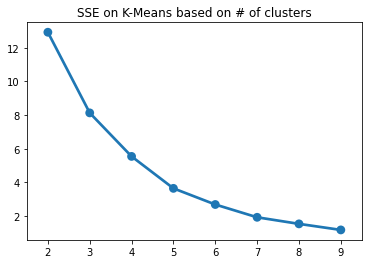

In [52]:
# To make sure our work becomes reproducible
inertia = []
# Iterating the process
for i in range(2, 10):
    # Instantiate the model
    model = KMeans(n_clusters=i)
    # Fit The Model
    model.fit(X_transformed)
    # Extract the error of the model
    inertia.append(model.inertia_)  # Visualize the model
sns.pointplot(x=list(range(2, 10)), y=inertia)
plt.title('SSE on K-Means based on # of clusters')
plt.show()

In [53]:
model = KMeans(n_clusters=3)  # Fit the model
model.fit(X_transformed)  # Predict the cluster from the data and save it
cluster = model.predict(X_transformed)
# Add to the dataframe and show the result
product_weekly_sum['cluster'] = cluster
product_weekly_sum.reset_index(inplace=True)

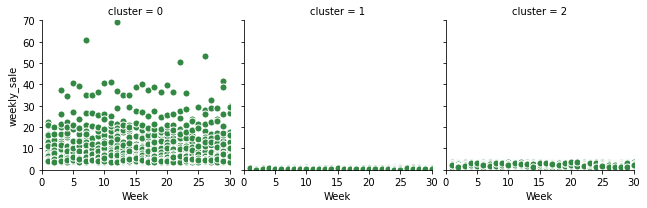

In [56]:
store_weekly_sum=filtered.groupby(["Week", "StoreCode"])["SalesQuantity"].sum().to_frame()

g = sns.FacetGrid(product_weekly_sum, col="cluster", margin_titles=True, height=3)
g.map(plt.scatter, "Week", "weekly_sale", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 30), ylim=(0, 70))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


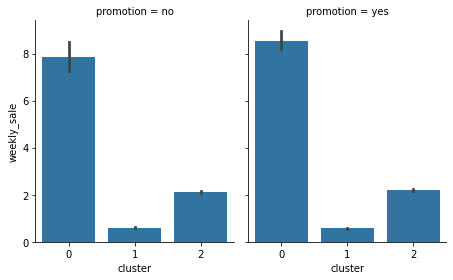

In [57]:
g = sns.FacetGrid(product_weekly_sum, col="promotion", height=4, aspect=.8)
g.map(sns.barplot, "cluster", "weekly_sale")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


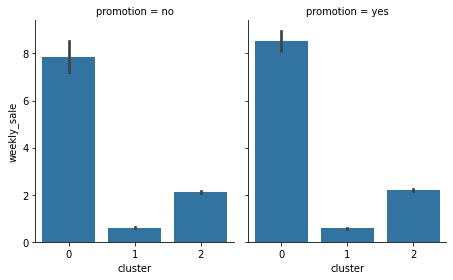

In [59]:
g = sns.FacetGrid(product_weekly_sum, col="promotion", height=4, aspect=.8)
g.map(sns.barplot, "cluster", "weekly_sale")

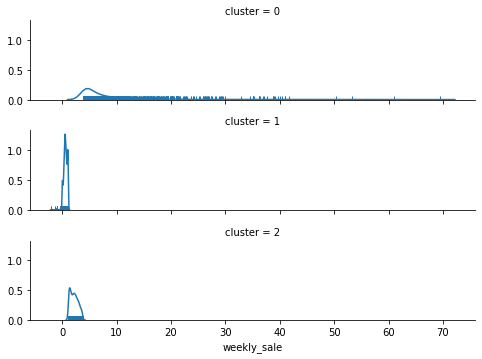

In [60]:
g = sns.FacetGrid(product_weekly_sum, row="cluster",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "weekly_sale", hist=False, rug=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


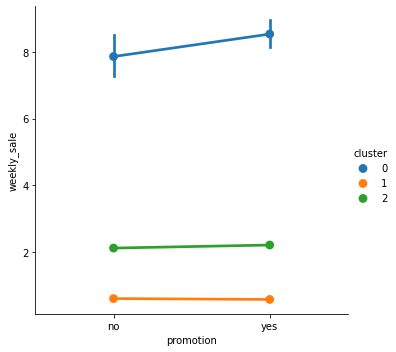

In [62]:
sns.factorplot(data= product_weekly_sum, 
               x= 'promotion',
               y= 'weekly_sale',
              hue="cluster")

In [63]:
product_weekly_sum.head()

,Week,ProductCode,promotion,weekly_sale,cluster
0,1,1,no,3.980392,0
1,1,2,no,2.340000,2
2,1,3,no,2.810811,2
3,1,4,no,2.895833,2
4,1,5,no,2.963636,2
